# Lab 2.1 : Image classification [Keras model]

<img src="details/Residual.png">
# cr. https://arxiv.org/pdf/1512.03385.pdf

In [3]:
%matplotlib inline
import warnings; warnings.simplefilter('ignore')

### Standard Library
import cv2
import time
import PIL.Image
import IPython.display
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

### Keras Library
import keras
from keras.models import load_model
import keras.backend as K
from keras.applications.resnet50 import ResNet50

### TensorRT and Tensorflow Library
from tensorflow.python.platform import gfile
from tensorflow.core.protobuf import config_pb2 as cpb2
from tensorflow.python.framework import ops as ops
from tensorflow.python.ops import array_ops as aops
from tensorflow.python.framework import importer as importer
from tensorflow.python.client import session as csess
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.INFO)

# Set number of GPUs
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [4]:
model_path = "ResNet50.h5"
infer_model = load_model(model_path)

#infer_model = ResNet50(weights='imagenet')
#infer_model.save("ResNet50.h5")

In [5]:
imagenet_list = open('imagenet_classes.txt','r')
imagenet_label = []

for i in imagenet_list:
    if len(i)>1:
        imagenet_label.append(i.split(",")[0])

In [7]:
# Prepare data
img_path = 'image/tan.jpg'
img = cv2.imread(img_path)

# Resize image to 224 x224  
img = cv2.resize(img, (224, 224)) 

# Convert BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Reshape input for 1 batch 
img = np.reshape(img,[1,224,224,3])

print(img.shape)

(1, 224, 224, 3)


<function matplotlib.pyplot.show(*args, **kw)>

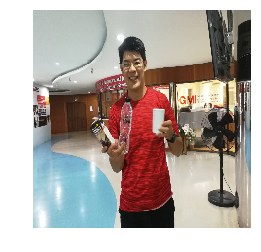

In [8]:
plt.axis('off')
plt.imshow(img[0])
plt.show

In [9]:
k_time = []
for i in range(0,101):
    t1 = time.time()
    result = infer_model.predict(img)
    predict = np.argmax(result)
    t2 = time.time()
    if i!=0:
        k_time.append((t2-t1))
        if i%10==0:
            print("Step %d : %f" %(i,(t2-t1)))
    else:
        print("Warm up : %f" %(t2-t1))
print("Predict time average: %f" %(sum(k_time)/100.))
print("Predict class : "+imagenet_label[predict])

Warm up : 1.169613
Step 10 : 0.346067
Step 20 : 0.327860
Step 30 : 0.340994
Step 40 : 0.345752
Step 50 : 0.353605
Step 60 : 0.332841
Step 70 : 0.335703
Step 80 : 0.334587
Step 90 : 0.337813
Step 100 : 0.337417
Predict time average: 0.340041
Predict class :  'goblet'
